In [10]:
#Prepare Python Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load Dataframe
data = pd.read_csv('/kaggle/input/hose-market/CafeF.HSX.Upto07.03.2025.csv')

# Rename column <DTYYYYMMDD> to Date
data.rename(columns={'<DTYYYYMMDD>': '<Date>'}, inplace=True)

# Convert <DTYYYYMMDD> from number to date format
data['<Date>'] = pd.to_datetime(data['<Date>'], format='%Y%m%d')

# Filter Stock Data for Analytics (SSI Stock in 10 years)
start_date = datetime.now()
end_date = datetime(start_date.year-10, start_date.month, start_date.day)
df = data[(data['<Ticker>']=='SSI') & (data['<Date>'] >= end_date) & (data['<Date>'] <= start_date)]

# Sort date and index in ascending
df = df.iloc[::-1]
df = df.reset_index(drop = True, inplace = False)

print(df.head())
print(df.tail())

#Get the duration of data set
print("Starting date: ", df.iloc[0]['<Date>'])
print("Ending date: ", df.iloc[-1]['<Date>'])
print("Duration: ", df.iloc[-1]['<Date>'] - df.iloc[0]['<Date>'])

  <Ticker>     <Date>  <Open>  <High>   <Low>  <Close>  <Volume>
0      SSI 2015-03-11  6.5013  6.5013  6.4154   6.4163   1280070
1      SSI 2015-03-12  6.4154  6.4440  6.3294   6.4163   1332560
2      SSI 2015-03-13  6.4440  6.4726  6.3867   6.3876    854900
3      SSI 2015-03-16  6.3867  6.4154  6.3008   6.3017   1281810
4      SSI 2015-03-17  6.3008  6.3867  6.3008   6.3590    927590
     <Ticker>     <Date>  <Open>  <High>  <Low>  <Close>  <Volume>
2492      SSI 2025-03-03   26.30   26.80  26.15    26.60  25645100
2493      SSI 2025-03-04   26.45   26.60  26.10    26.35  24072400
2494      SSI 2025-03-05   26.40   26.65  26.10    26.10  27564200
2495      SSI 2025-03-06   26.20   26.95  26.20    26.90  44988800
2496      SSI 2025-03-07   27.10   27.15  26.80    26.90  22896800
Starting date:  2015-03-11 00:00:00
Ending date:  2025-03-07 00:00:00
Duration:  3649 days 00:00:00


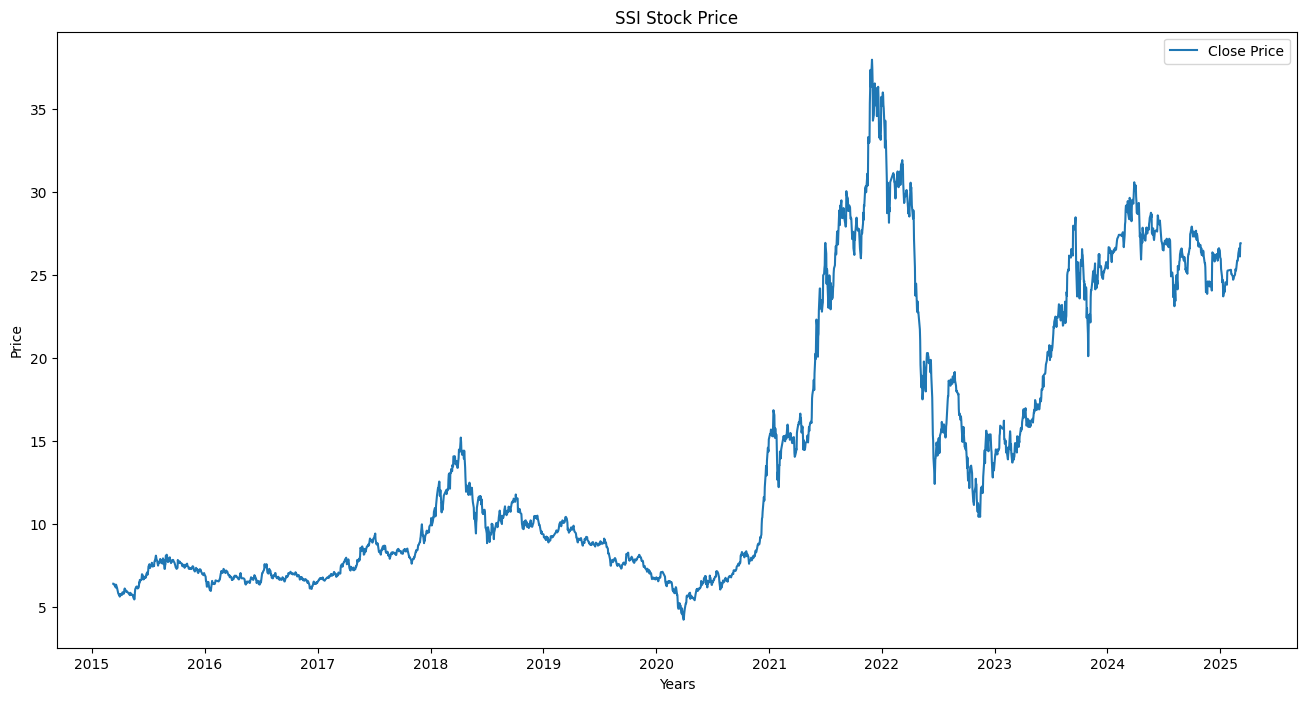

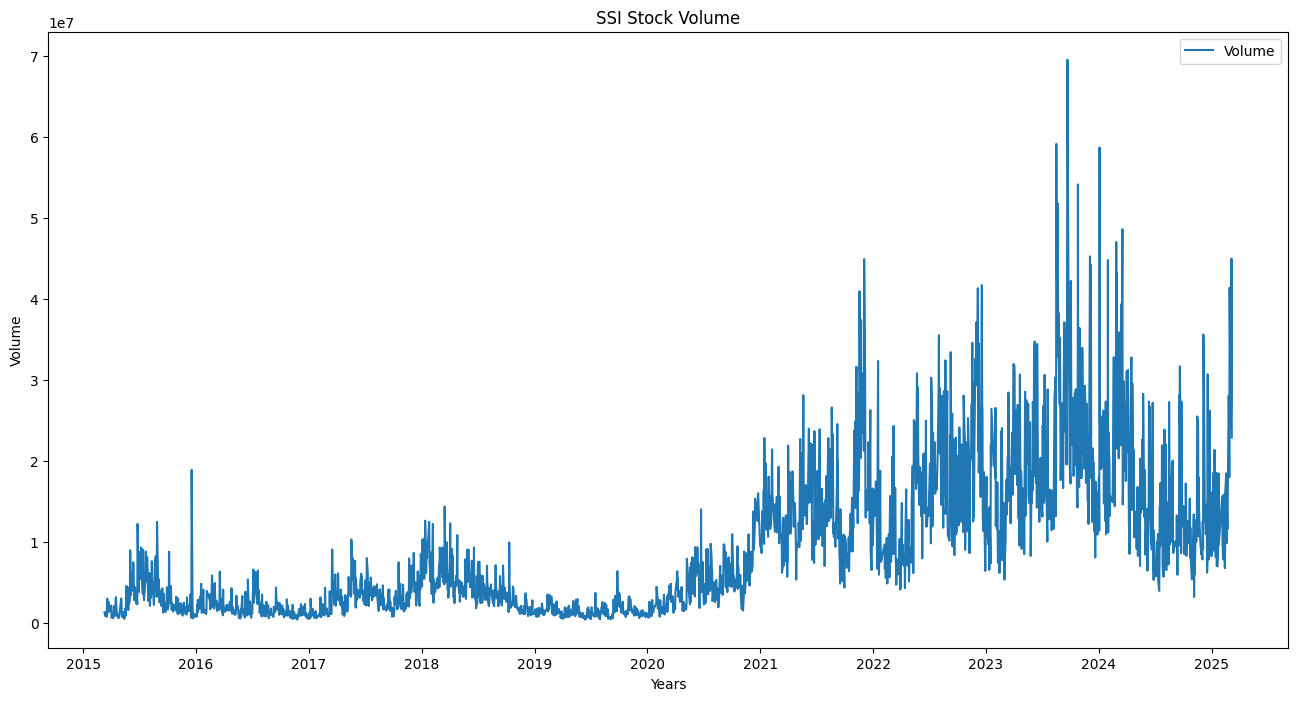

In [11]:
# Plot Stock Price
plt.figure(figsize=(16,8))
plt.plot(df['<Date>'], df['<Close>'], label='Close Price')
plt.title('SSI Stock Price')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend()

# Plot Stock Volume
plt.figure(figsize=(16,8))
plt.plot(df['<Date>'], df['<Volume>'], label='Volume')
plt.title('SSI Stock Volume')
plt.xlabel('Years')
plt.ylabel('Volume')
plt.legend()

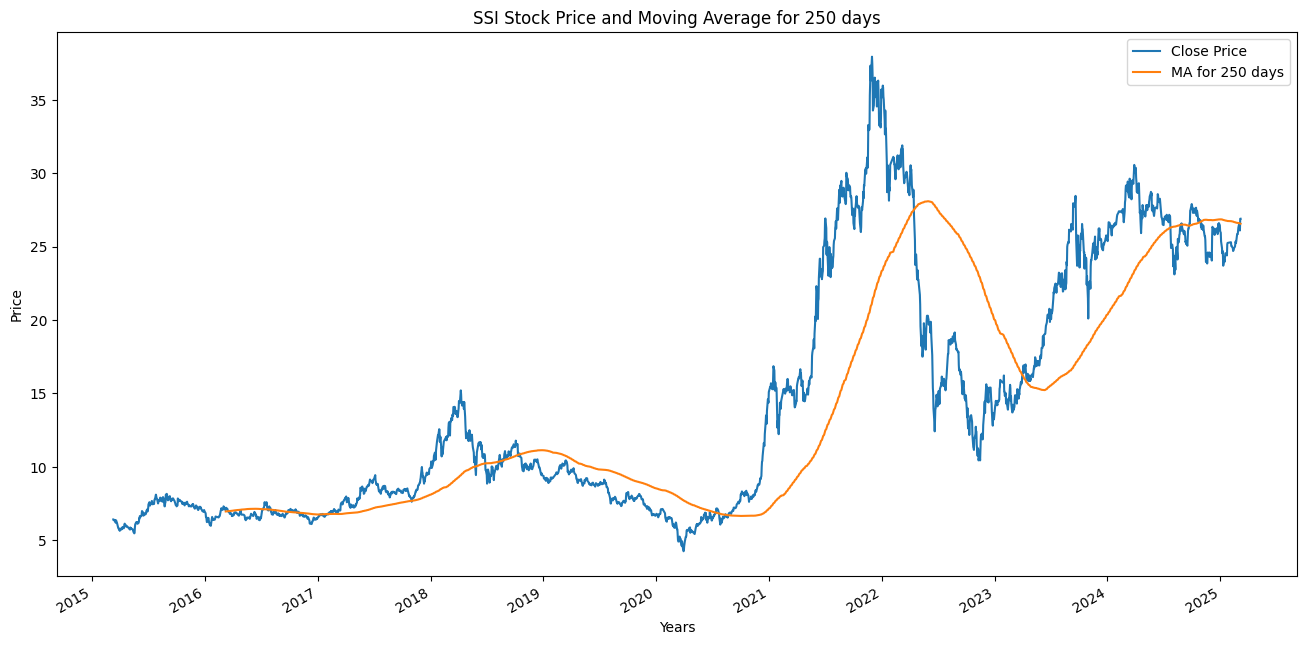

In [12]:
# Calculate Moving Average for 250 days
df['MA for 250 days'] = df['<Close>'].rolling(window=250).mean()
df['MA for 250 days'][0:250].tail()

plot_graph = df[['<Date>', '<Close>', 'MA for 250 days']].plot(x='<Date>', y=['<Close>', 'MA for 250 days'], figsize=(16,8))
plot_graph.set_title('SSI Stock Price and Moving Average for 250 days')
plot_graph.set_xlabel('Years')
plot_graph.set_ylabel('Price')
plot_graph.legend(['Close Price', 'MA for 250 days'])

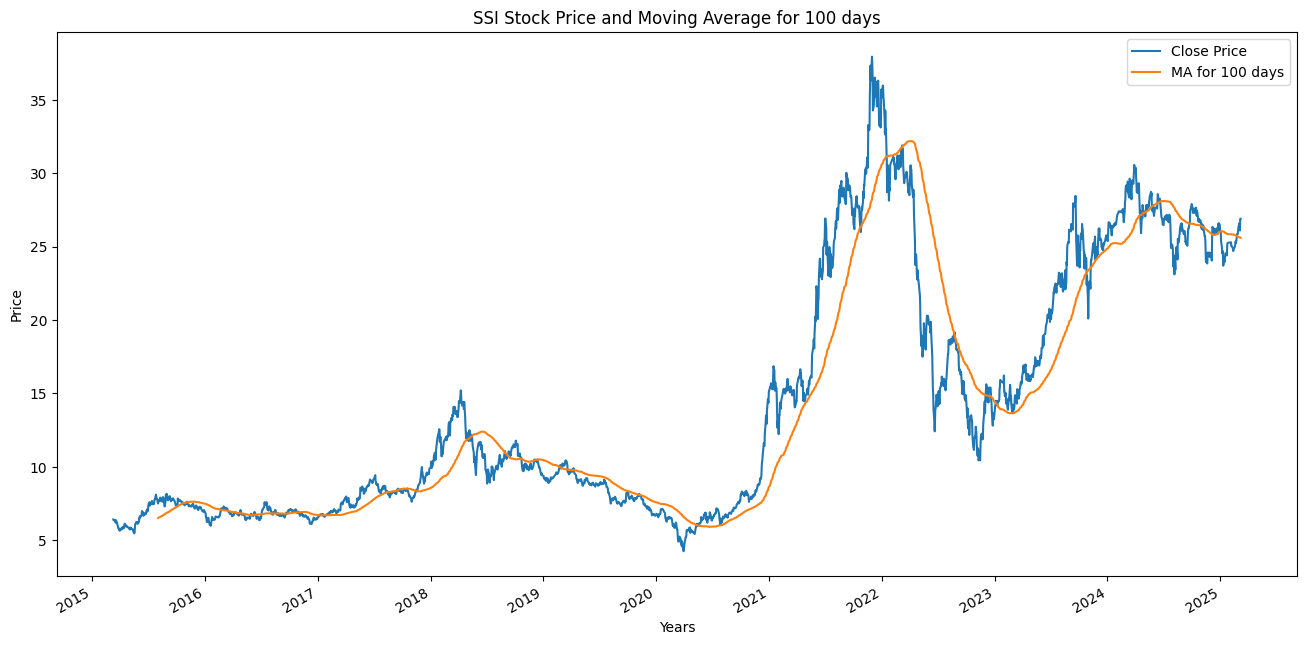

In [13]:
# Calculate Moving Average for 100 days
df['MA for 100 days'] = df['<Close>'].rolling(window=100).mean()
df['MA for 100 days'][0:100].tail()

plot_graph = df[['<Date>', '<Close>', 'MA for 100 days']].plot(x='<Date>', y=['<Close>', 'MA for 100 days'], figsize=(16,8))
plot_graph.set_title('SSI Stock Price and Moving Average for 100 days')
plot_graph.set_xlabel('Years')
plot_graph.set_ylabel('Price')
plot_graph.legend(['Close Price', 'MA for 100 days'])

Text(0, 0.5, 'Price')

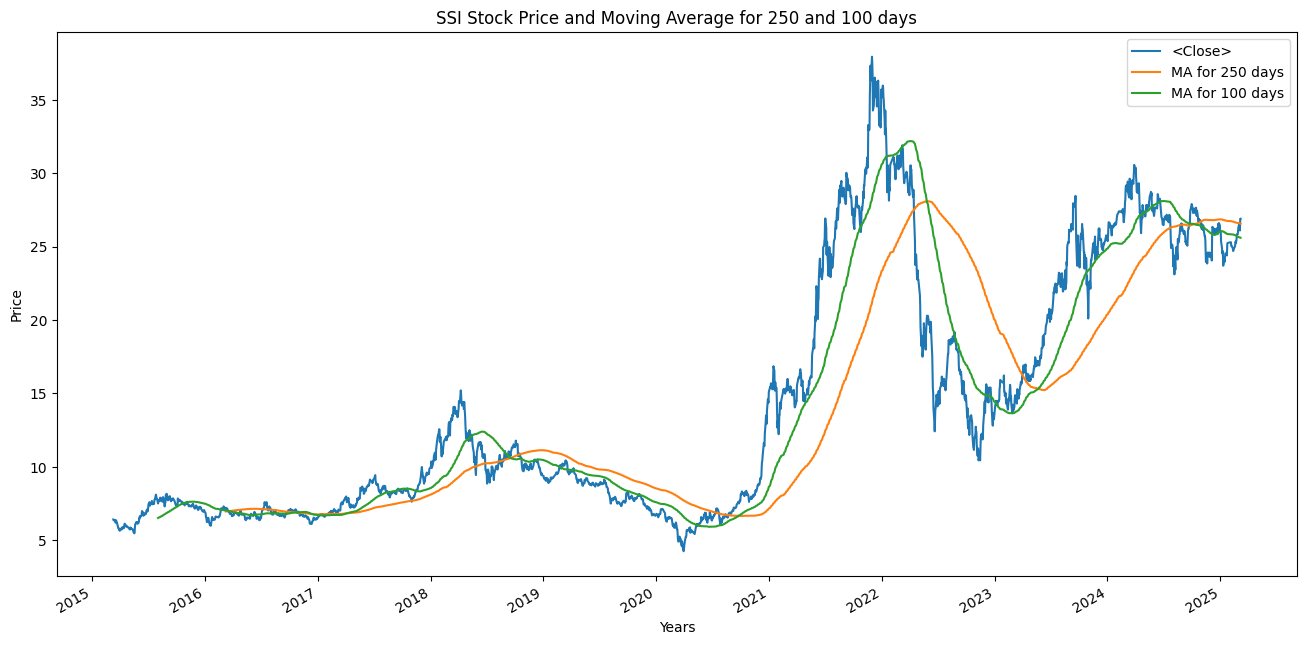

In [14]:
plot_graph = df[['<Date>', '<Close>', 'MA for 250 days', 'MA for 100 days']].plot(x='<Date>', y=['<Close>', 'MA for 250 days', 'MA for 100 days'], figsize=(16,8))
plot_graph.set_title('SSI Stock Price and Moving Average for 250 and 100 days')
plot_graph.set_xlabel('Years')
plot_graph.set_ylabel('Price')


Daily Return Statistics:
count    2496.000000
mean        0.000849
std         0.023462
min        -0.069973
25%        -0.009869
50%         0.000000
75%         0.011422
max         0.070522
Name: Daily Return, dtype: float64


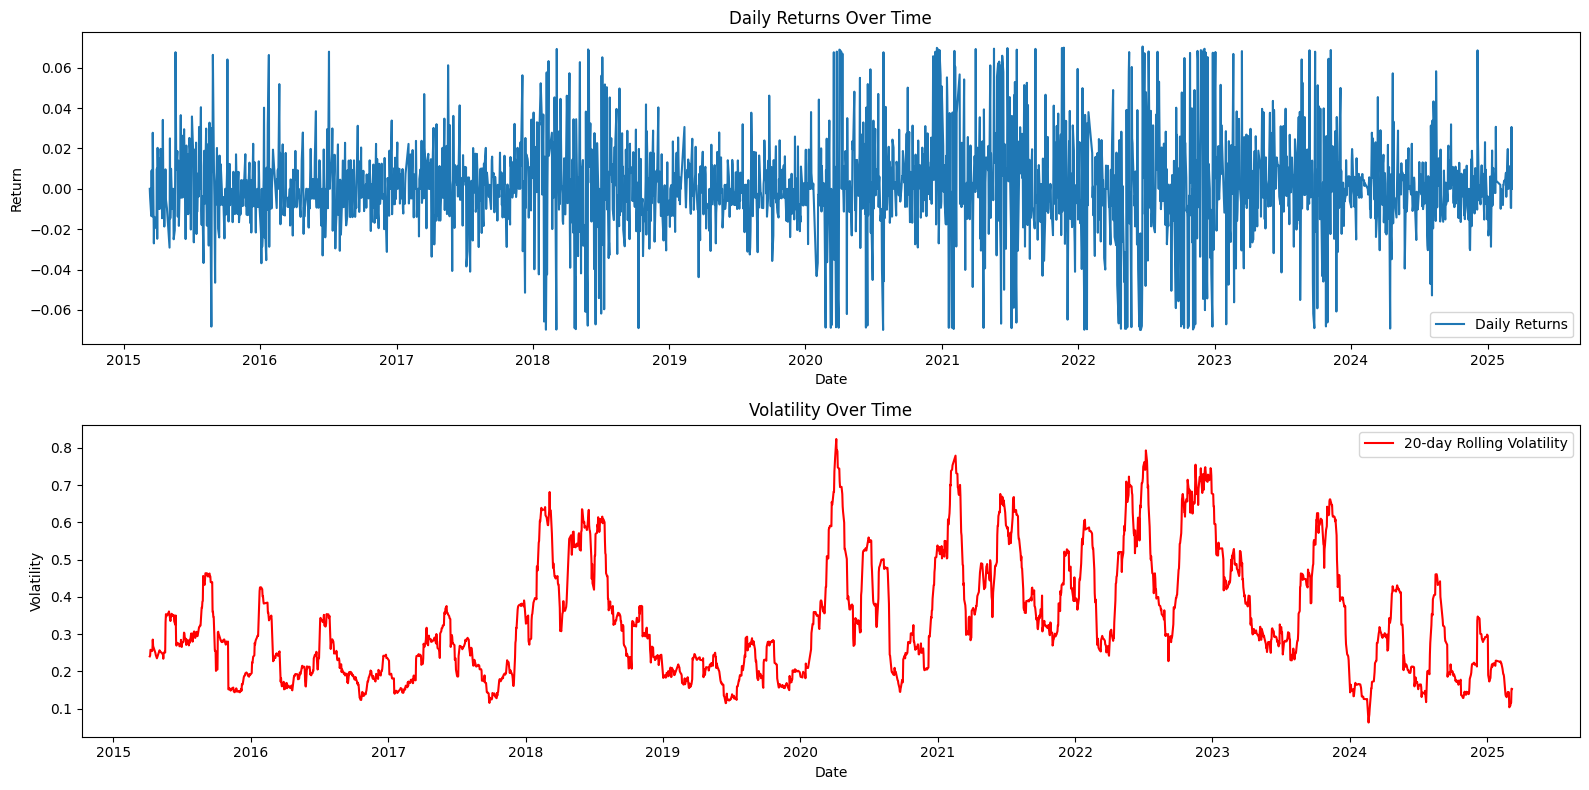


Recent Volatility:
         <Date>  Volatility
2492 2025-03-03    0.108659
2493 2025-03-04    0.116766
2494 2025-03-05    0.116239
2495 2025-03-06    0.153810
2496 2025-03-07    0.153006


In [15]:
# Calculate and analyze Daily Returns
df['Daily Return'] = df['<Close>'].pct_change()

# Statistical Analysis of Daily Returns
print("\nDaily Return Statistics:")
print(df['Daily Return'].describe())

# Calculate Rolling Mean and Standard Deviation
window = 20  # 20-day rolling
df['Rolling Mean'] = df['<Close>'].rolling(window=window).mean()
df['Rolling Std'] = df['<Close>'].rolling(window=window).std()
df['Volatility'] = df['Daily Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Plot Daily Returns and Volatility
plt.figure(figsize=(16, 8))

# Daily Returns subplot
plt.subplot(2, 1, 1)
plt.plot(df['<Date>'], df['Daily Return'], label='Daily Returns')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

# Volatility subplot
plt.subplot(2, 1, 2)
plt.plot(df['<Date>'], df['Volatility'], label='20-day Rolling Volatility', color='red')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

# Print recent volatility
print("\nRecent Volatility:")
print(df[['<Date>', 'Volatility']].tail())

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0310 - val_loss: 0.0011
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0020 - val_loss: 9.8594e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0015 - val_loss: 9.1099e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0016 - val_loss: 8.6407e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0014 - val_loss: 7.9094e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0013 - val_loss: 7.8314e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0015 - val_loss: 7.0338e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 7.2890e-04
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0010 - val_loss: 6.8610e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0014 - val_loss: 6.6058e-04
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━

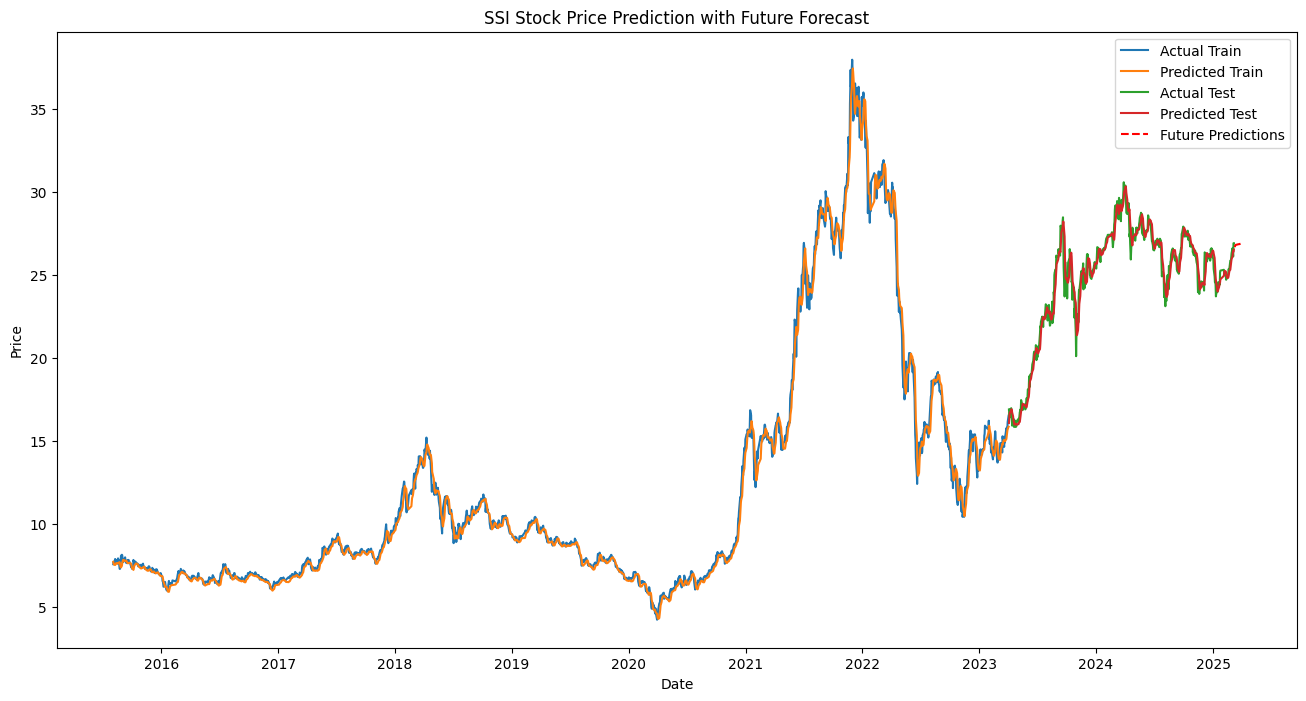

Shapes:
train_dates: (1917,)
train_predict: (1917, 1)
test_dates: (480,)
test_predict: (480, 1)

Future price predictions for the next 15 days:
2025-03-10: 26.67
2025-03-11: 26.74
2025-03-12: 26.77
2025-03-13: 26.79
2025-03-14: 26.81
2025-03-17: 26.81
2025-03-18: 26.82
2025-03-19: 26.83
2025-03-20: 26.83
2025-03-21: 26.84
2025-03-24: 26.84
2025-03-25: 26.85
2025-03-26: 26.86
2025-03-27: 26.86
2025-03-28: 26.87


In [16]:
# Import additional libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math

# Prepare the data for LSTM
# Select only the closing price
data = df['<Close>'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (number of time steps)
seq_length = 100
X, y = create_sequences(scaled_data, seq_length)

# Reshape input data for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile with specific learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with try-except block
try:
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
except ValueError as e:
    print(f"Error during training: {e}")
    print(f"Input shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Function to predict future values
def predict_future(model, last_sequence, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        # Get prediction for next day
        current_prediction = model.predict(current_sequence.reshape(1, seq_length, 1))
        future_predictions.append(current_prediction[0,0])
        
        # Update sequence by removing first element and adding the prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = current_prediction
        
    return np.array(future_predictions)

# Get the last sequence from our data
last_sequence = scaled_data[-seq_length:]

# Function to generate business dates (excluding weekends)
def get_business_dates(start_date, n_days):
    business_dates = []
    current_date = start_date
    while len(business_dates) < n_days:
        current_date = current_date + pd.Timedelta(days=1)
        if current_date.weekday() < 5:  # Monday = 0, Friday = 4
            business_dates.append(current_date)
    return pd.DatetimeIndex(business_dates)

# Predict next 15 days
n_future = 15
future_predictions = predict_future(model, last_sequence, n_future)

# Scale back to original price
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Generate future business dates (excluding weekends)
last_date = df['<Date>'].iloc[-1]
future_dates = get_business_dates(last_date, n_future)

# Plotting results
plt.figure(figsize=(16,8))

# Calculate correct date ranges
train_dates = df['<Date>'].values[seq_length:len(train_predict)+seq_length]
test_dates = df['<Date>'].values[len(train_predict)+seq_length:len(train_predict)+len(test_predict)+seq_length]

# Plot with aligned dimensions
plt.plot(train_dates, y_train_inv, label='Actual Train')
plt.plot(train_dates, train_predict, label='Predicted Train')
plt.plot(test_dates, y_test_inv, label='Actual Test')
plt.plot(test_dates, test_predict, label='Predicted Test')
plt.plot(future_dates, future_predictions, 'r--', label='Future Predictions')
plt.title('SSI Stock Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print shapes for verification
print("Shapes:")
print(f"train_dates: {train_dates.shape}")
print(f"train_predict: {train_predict.shape}")
print(f"test_dates: {test_dates.shape}")
print(f"test_predict: {test_predict.shape}")

# Print future predictions
print("\nFuture price predictions for the next 15 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]:.2f}")